# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
import sys
 
# setting path
sys.path.append('..')

from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle
from statannotations.Annotator import Annotator
from collections import defaultdict
from scipy import stats
import mne
import glob 
import random
import math
import statsmodels.api as sm

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
import matplotlib
matplotlib.use('Agg')

# Prep

In [3]:
from mna.utils.rnapp_data_format import read_all_files

In [4]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/pupil_exposure/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]

interrupted_sessions = [(13,1), (22,1)]
reference_ica = "sbj20ssn03"
save_data_pkl = True # save data into pickle files
save_ica_plts = False # save ICA components plots
epoch_raw_eeg = False # epoching raw data
motor_events = True
preturn = 1000
rs = 64 # random seed

# Read Annotated Data

In [8]:
motor_events = pd.read_excel(f"{data_dir}/annotated/all_motor_break_events.xlsx")

In [9]:
# get the exposure periods of interest
exposure_periods = defaultdict(list)
for sub in motor_events.sbj_ssn.unique():
    start_intervals = []
    found_calib = False
    sub_df = motor_events.loc[motor_events.sbj_ssn==sub].reset_index(drop=True)
    sbj_ssn = sub_df.sbj_ssn.iloc[0]
    exposure_df = sub_df.loc[(sub_df.calibration_trials==1) | (sub_df.calibration_trials==2)]
    for index, period in exposure_df.iterrows():
        end_interval = period.end_intervals
        start_interval = period.start_intervals
        exposure_periods[sbj_ssn].append((start_interval, end_interval))

# link the ids with the file
for each_file in onlyfiles:
    input_path = data_dir + each_file

    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]

    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    if sbj+ssn in exposure_periods:
        exposure_periods[sbj+ssn].append(input_path)

In [10]:
channel = 'L Pupil Diameter'
freq = 120
calib_densities = [0, 0, 0.3, 0.5, 0.7, 0.8, 0.8, 0.7, 0.5, 0.3, 0] # sequence of densities, the first we drop
calib_trial_duration = 5 # seconds
calib_blocks = [2, 12] # 1st block is practice, second is calib, and 12th is second calib (not all sessions reached here)

num_repeats = int(freq*calib_trial_duration)
calib_opacities = [val for val in calib_densities for _ in range(num_repeats)]
start_secs = 0 # how many seconds into the movementless period to start the calibration period


In [8]:
all_dfs = []
for pp_sess in exposure_periods:
    print('processing', pp_sess)
    input_path = exposure_periods[pp_sess][-1]
    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))
    
    eye_channel='Unity_ViveSREyeTracking'
    df_eye = pd.DataFrame(rns_data[eye_channel][0], columns=rns_data[eye_channel][1],
                          index=rns_data[eye_channel][2]['ChannelNames']).T
    df_eye = df_eye.reset_index().rename(columns={'index':'timestamp'})
    df_eye.timestamp -= df_eye.timestamp[0]
    participant_df = []
    for calib_period_index,period in enumerate(exposure_periods[pp_sess][:-1]):
        print('calib_period_index', calib_period_index)
        sub_df = df_eye.loc[(df_eye.timestamp >= period[0]) & (df_eye.timestamp <= period[1]), ['timestamp', channel]].reset_index(drop=True).reset_index()
        sub_df = sub_df.rename(columns={'index': 'ref_timestamp'})
        sub_df['sub_sess'] = pp_sess
        sub_df['calib_period_index'] = calib_period_index
        sub_df['opacities'] = np.NaN
        if len(calib_opacities)>len(sub_df): # we don't have enough eye tracking data
            print('not enough data')
            continue
        sub_df.loc[start_secs*freq:start_secs*freq+len(calib_opacities)-1,'opacities'] = calib_opacities
        
        sub_df[channel+' Transform'] = sub_df[channel].replace(-1, np.nan)
        
        # get first found pupil and baseline adjust
        starting_diameter_idx = sub_df.loc[start_secs*freq:start_secs*freq+len(calib_opacities)-1,channel].notna().idxmax()
        starting_diameter = sub_df[channel].iloc[starting_diameter_idx]
        sub_df[channel+' Transform'] = sub_df[channel+' Transform'] - starting_diameter
        
        sub_df[channel] = sub_df[channel].interpolate(method ='linear', limit_direction ='forward')
        sub_df[channel+' Transform'] = sub_df[channel+' Transform'].rolling(30).mean() # 250 ms meaning average filter
        participant_df.append(sub_df)
    participant_df = pd.concat(participant_df)
    # fit opacities to pupil diameter
    sub_df_nonna = participant_df[['L Pupil Diameter Transform','opacities']].dropna()
    Y = sub_df_nonna['L Pupil Diameter Transform']
    X = sub_df_nonna['opacities']
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    participant_df['w_opacities'] = results.params['opacities']
    participant_df['const'] = results.params['const']
    participant_df['p_opacities'] = results.pvalues['opacities']
    all_dfs.append(participant_df)
all_dfs = pd.concat(all_dfs)


processing sbj20ssn03
calib_period_index 0
calib_period_index 1
processing sbj14ssn03


KeyboardInterrupt: 

# Summary Stats

In [12]:
all_dfs[['sub', 'sess']] = all_dfs['sub_sess'].str.split('sbj', 1, expand=True)[1].str.split('ssn', 1, expand=True)
agg_df = all_dfs.groupby(['sub']).mean()[['L Pupil Diameter','w_opacities','const','p_opacities']]
agg_df.to_csv(f"{output_dir}participant_level.csv")

# Plots

## Pupil vs. opacity by pp and session

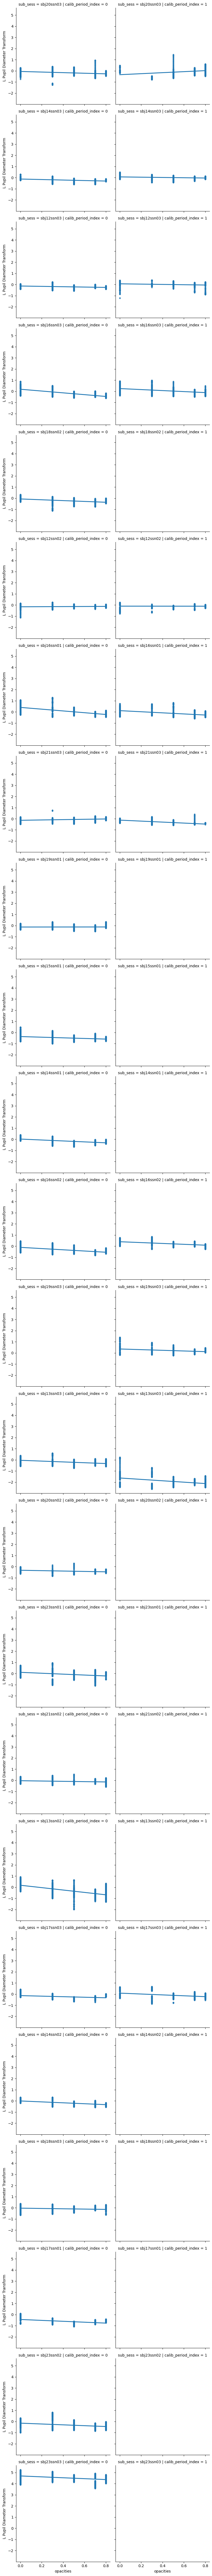

In [39]:
%matplotlib inline

sns.lmplot(
    data=all_dfs, x="opacities", y=channel+' Transform', col="calib_period_index",row='sub_sess',
    palette="muted", ci=None, 
    height=4, scatter_kws={"s": 10, "alpha": .6}
)
plt.savefig(f"{output_dir}left_pupil_v_opacity.png", dpi=300)

## Baseline corrected pupil vs. time during exposure period

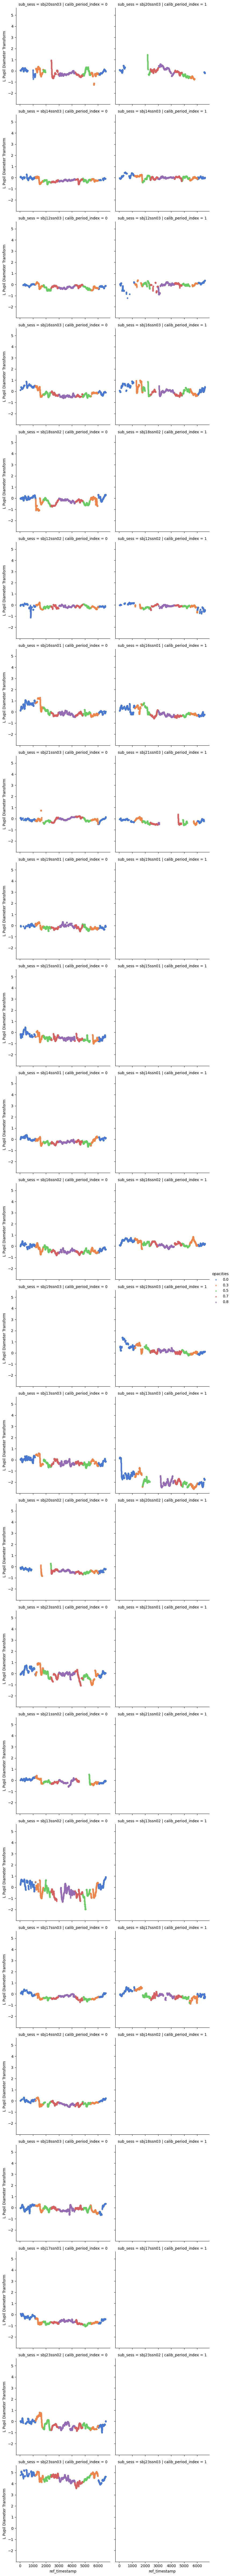

In [44]:
%matplotlib inline

sns.lmplot(
    data=all_dfs, x="ref_timestamp", y=channel+' Transform', col="calib_period_index", hue="opacities", row='sub_sess',
    palette="muted", ci=None, fit_reg=False,
    height=4, scatter_kws={"s": 10, "alpha": .6}
)
plt.savefig(f"{output_dir}left_pupil_v_time_by_opacity.png", dpi=300)

In [13]:
agg_df

,L Pupil Diameter,w_opacities,const,p_opacities
sub,,,,
12,1.708079,-0.050239,-0.092654,4.183002e-04
13,2.833859,-0.597915,-0.483609,2.674861e-29
14,2.199291,-0.298532,-0.012316,1.030092e-199
15,2.469027,-0.283800,-0.370550,1.394436e-172
16,2.992173,-0.589300,0.206734,0.000000e+00
17,2.293287,-0.351440,-0.179367,0.000000e+00
18,2.332976,-0.257408,-0.052547,4.067619e-52
19,2.495793,-0.145671,0.114804,2.024116e-01
20,2.212060,-0.056240,-0.200606,5.400560e-01
